# Fallback - Insert Retention Scores (MSSQL)
* StelllarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* Feb 28, 2022

In [1]:
import getpass
import pyodbc
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from datetime import datetime
from pytz import timezone
from pycaret.classification import *

warnings.filterwarnings('ignore')

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [7]:
# connect to SQL Server.
SERVER = '52.44.171.130' 
DATABASE = 'datascience' 
USERNAME = 'dsAdminWrite' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

In [8]:
lkupclientid = 45
stlrDBname = 'stlrRays'

cursor = CNXN.cursor()

storedProc = (
    f"""Exec {stlrDBname}.[ds].[getRetentionScoringModelData] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)

# apply some data transformations
df["year"] = pd.to_numeric(df["year"])

CNXN.commit()
cursor.close()

df.shape

In [4]:
df.year.value_counts()

2022    2958
2021    2593
2019    2112
2017    1841
2018    1825
Name: year, dtype: int64

### We should specify the features used in our model:

In [61]:
# choose the features for the stellar base retention model
features = [
    "dimCustomerMasterId",
    "attendancePercent",
    "distToVenue",
    "isNextYear_Buyer",
    "productGrouping",
    "recency",
    "recentDate",
    "source_tenure",
    "totalSpent",
    "year"
]

# copy your main dataframe
df_dataset = df

# choose the features & train year & test year
df_dataset = df_dataset[features]
df_dataset["year"] = pd.to_numeric(df_dataset["year"])
df_dataset = df_dataset.loc[df_dataset["year"] <= 2019]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (13716, 10)
Unseen Data For Predictions: (2421, 10)



### Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [62]:
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.85,
    data_split_shuffle=True,
    ignore_features=[
        "dimCustomerMasterId",
        "productGrouping",
        "recentDate",
        "year"
    ],
    silent=True,
    verbose=False,
    numeric_features=[
        "attendancePercent",
        "distToVenue",
        "recency",
        "source_tenure",
        "totalSpent"
    ]
);

### The evaluation output prints a score grid that shows average Accuracy, AUC, Recall, Precision, F1 and Kappa accross the folds (10 by default) along with training time:

In [63]:
model_matrix = compare_models(
    fold= 10,
    include= ["lr","xgboost"],
    n_select= 2,
    probability_threshold= 0.75
)
results = pull()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.8327,0.9089,0.8542,0.8124,0.8327,0.6657,0.6666,0.3580
lr,Logistic Regression,0.5199,0.5984,0.8948,0.5044,0.6451,0.0567,0.0846,0.2610


In [64]:
models = []
for idx, m in enumerate(model_matrix):
    
    model = create_model(m)
    final_model = finalize_model(model)
    
    models.append({
        "name": str(results.iloc[idx]["Model"]),
        "model": final_model
    })

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.5240,0.5953,0.8873,0.5065,0.6449,0.0650,0.0936
1,0.5017,0.5847,0.8768,0.4936,0.6316,0.0218,0.0326
2,0.5223,0.5806,0.8893,0.5060,0.6450,0.0607,0.0884
3,0.5223,0.6042,0.8998,0.5059,0.6477,0.0612,0.0920
4,0.5120,0.5703,0.8946,0.5000,0.6415,0.0412,0.0630
5,0.5266,0.6257,0.9069,0.5084,0.6515,0.0697,0.1057
6,0.5266,0.6249,0.9033,0.5084,0.6506,0.0696,0.1043
7,0.5257,0.6189,0.9121,0.5078,0.6524,0.0683,0.1057
8,0.5185,0.5867,0.8856,0.5035,0.6420,0.0538,0.0783
9,0.5193,0.5931,0.8926,0.5040,0.6442,0.0557,0.0826


### Let's load in our 2021 season data and get retention scores using the model:

In [65]:
df_inference = df.loc[df["year"] >= 2021]
df_inference = df_inference.fillna(0)
df_inference = df_inference[features]

df_inference.shape

(5184, 10)

In [66]:
predictions = []
for idx, final_m in enumerate(models):
    
    df_predictions = (predict_model(final_m['model'], data=df_inference, raw_score=True))
    df_predictions = df_predictions[df_predictions["Score_1"] >= 0.025]
    final_m["predictions"] = df_predictions

### We can create some histograms to visualize each model distribution:

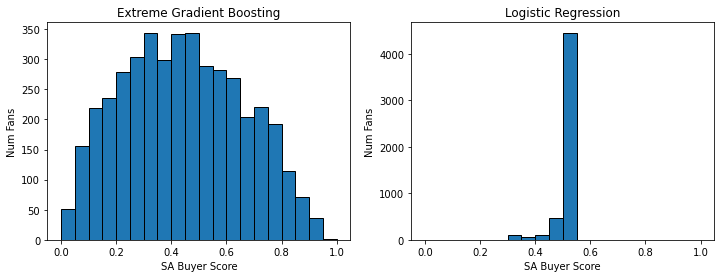

In [67]:
for idx, model in enumerate(models):
    
    plt.subplot(1, 4, idx+1)
    plt.title(model["name"])
    plt.ylabel("Num Fans")
    plt.xlabel("SA Buyer Score")
    plt.hist(model["predictions"]["Score_1"], bins=20, edgecolor="black", range=(0,1))
                            
plt.rcParams["figure.figsize"] = (25,4)
plt.show()

### We can also see how many purchases there are in each range of scores:

In [68]:
df_new = pd.DataFrame()

for idx, model in enumerate(models):
    df_new["Score"] = df_new.index
    df_new[str(models[idx]["name"])] = models[idx]["predictions"]["Score_1"].value_counts(bins=np.arange(0, 1.05, 0.05)).sort_index(ascending=False)

df_new.reset_index(inplace=True, drop=True)
df_new

,Score,Extreme Gradient Boosting,Logistic Regression
0,"(0.95, 1.0]",2,0
1,"(0.9, 0.95]",36,0
2,"(0.85, 0.9]",71,0
3,"(0.8, 0.85]",115,0
4,"(0.75, 0.8]",192,0
5,"(0.7, 0.75]",220,0
6,"(0.65, 0.7]",205,0
7,"(0.6, 0.65]",269,0
8,"(0.55, 0.6]",282,0
9,"(0.5, 0.55]",289,4452


### Select the model you would like to use for updating scores:

In [69]:
selected_model = "Extreme Gradient Boosting"

for model in models:
    if model["name"] == selected_model:

        df_scores = model["predictions"]
                                 
df_scores.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4251 entries, 16137 to 21320
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   dimCustomerMasterId  4251 non-null   int64  
 1   attendancePercent    4251 non-null   float64
 2   distToVenue          4251 non-null   float64
 3   isNextYear_Buyer     4251 non-null   int64  
 4   productGrouping      4251 non-null   object 
 5   recency              4251 non-null   int64  
 6   recentDate           4251 non-null   object 
 7   source_tenure        4251 non-null   int64  
 8   totalSpent           4251 non-null   float64
 9   year                 4251 non-null   int64  
 10  Label                4251 non-null   int64  
 11  Score_0              4251 non-null   float32
 12  Score_1              4251 non-null   float32
dtypes: float32(2), float64(3), int64(6), object(2)
memory usage: 431.7+ KB


### Optionally we can push these scores into QA so that we can see what the new scoring looks like in the CDP:

In [70]:
try:
    # connect to SQL Server.
    cnxn = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)
    cursor = cnxn.cursor()
    
    date_time_now = datetime.now().strftime("%m-%d-%Y %H:%M:%S")
    
    # create batches of dataframes based on batch size
    batch_size = 500
    df_scores_list = [
        df_scores[i:i + batch_size]
        for i in range(0, df_scores.shape[0], batch_size)
    ]

    # iterate through each batch and process retention scores
    for idx, scores in enumerate(df_scores_list):

        fields = f"""
            INSERT INTO ds.customerScores (
                dimCustomerMasterId,
                buyer_score,
                tenuredays,
                attendancePercentage,
                mostrecentattendance,
                year,
                lkupclientid,
                productgrouping,
                seasonYear,
                insertDate
            ) VALUES 
        """

        values_list = []
        for i, (index, row) in enumerate(scores.iterrows()):   

            values = f"""
                (
                    {str(row.dimCustomerMasterId)},
                    {str(round(row.Score_1,4))},
                    {str(row.source_tenure)},
                    {str(row.attendancePercent)},
                    '{str(row.recentDate)}',
                    {str(row.year)},
                    {str(lkupclientid)},
                    '{str(row.productGrouping)}',
                    {str(row.year)},
                    '{str(date_time_now)}'
                )
            """

            values_list.append(values)

            if((i+1)%100 == 0):
                print(f" > BATCH {idx+1} ROWS: {i+1}-{i+10} | {round(100*(i+1)/len(scores),0)}% COMPLETED")

        insert_statement = fields + ",".join(values_list)+";"

        cursor.execute(insert_statement)
        cnxn.commit()
        
        print(f"BATCH {idx+1} PROCESSED", end="\n\n")
    
    print("RETENTION SCORES WRITTEN TO DATABASE")

except Exception as err:
    print("ERROR INSERTING RETENTION SCORES TO DATABASE:", err)
    

 > BATCH 1 ROWS: 100-109 | 20.0% COMPLETED
 > BATCH 1 ROWS: 200-209 | 40.0% COMPLETED
 > BATCH 1 ROWS: 300-309 | 60.0% COMPLETED
 > BATCH 1 ROWS: 400-409 | 80.0% COMPLETED
 > BATCH 1 ROWS: 500-509 | 100.0% COMPLETED
BATCH 1 PROCESSED

 > BATCH 2 ROWS: 100-109 | 20.0% COMPLETED
 > BATCH 2 ROWS: 200-209 | 40.0% COMPLETED
 > BATCH 2 ROWS: 300-309 | 60.0% COMPLETED
 > BATCH 2 ROWS: 400-409 | 80.0% COMPLETED
 > BATCH 2 ROWS: 500-509 | 100.0% COMPLETED
BATCH 2 PROCESSED

 > BATCH 3 ROWS: 100-109 | 20.0% COMPLETED
 > BATCH 3 ROWS: 200-209 | 40.0% COMPLETED
 > BATCH 3 ROWS: 300-309 | 60.0% COMPLETED
 > BATCH 3 ROWS: 400-409 | 80.0% COMPLETED
 > BATCH 3 ROWS: 500-509 | 100.0% COMPLETED
BATCH 3 PROCESSED

 > BATCH 4 ROWS: 100-109 | 20.0% COMPLETED
 > BATCH 4 ROWS: 200-209 | 40.0% COMPLETED
 > BATCH 4 ROWS: 300-309 | 60.0% COMPLETED
 > BATCH 4 ROWS: 400-409 | 80.0% COMPLETED
 > BATCH 4 ROWS: 500-509 | 100.0% COMPLETED
BATCH 4 PROCESSED

 > BATCH 5 ROWS: 100-109 | 20.0% COMPLETED
 > BATCH 5 ROWS: 

### Run the stored procedure to push scores from Data Science table to Stlr table:

In [71]:
cnxn = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)
cursor = cnxn.cursor()

try:
    cursor.execute(
        f"Exec [DataScience].[DW].[factCustomerretention_INCR_LOAD_procVersion] {lkupclientid}, 2021"
    )
    cnxn.commit()

except Exception as err:
    print("ERROR RUNNING RETENTION SCORE STORED PROCEDURE:", err)